# Offline Handwritten Signature Detection & Verification

## Project Overview
This project builds an offline signature verification system using a Convolutional Neural Network (CNN).  
**Problem**: Binary classification to distinguish between **Genuine** and **Forged** signatures.

## 1. Project Setup
We start by setting up our environment, importing necessary libraries, and ensuring reproducibility.

In [27]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Set Random Seeds for Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Detected: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

print(f"TensorFlow Version: {tf.__version__}")

No GPU detected. Running on CPU.
TensorFlow Version: 2.20.0


In [28]:
## 2. DATA CONFIGURATION
SOURCE_FORGED = "DataSet/full_forg"   # Folder containing our forged signature images
SOURCE_GENUINE = "DataSet/full_org"   # Folder containing our genuine signature images

# The directory where the organized train/test data will be created
DATA_DIR = "DataSet/data"

# Hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224) 
SPLIT_RATIO = 0.8      # 80% Training, 20% Testing

In [29]:
def prepare_dataset(forged_dir, genuine_dir, data_dir, split_ratio=0.8, force=True):
    """
    Prepares dataset from flat folder structure (all images in 2 folders)
    
    Args:
        forged_dir: Path to folder containing forged signatures
        genuine_dir: Path to folder containing genuine signatures
        data_dir: Output directory for organized data
        split_ratio: Train/test split ratio (default 0.8 = 80% train, 20% test)
        force: If True, deletes existing data_dir before creating new one
    """
    
    # Check if source directories exist
    if not os.path.exists(forged_dir) or not os.path.exists(genuine_dir):
        print(f"Error: Source directories not found.\nExpected '{forged_dir}' and '{genuine_dir}'.")
        return

    # Force recreation if requested
    if os.path.exists(data_dir) and force:
        print(f"Removing existing '{data_dir}' folder to ensure clean setup...")
        shutil.rmtree(data_dir)
    elif os.path.exists(data_dir) and not force:
        print(f"'{data_dir}' already exists. Set force=True to recreate.")
        return

    print(f"Preparing dataset from '{forged_dir}' and '{genuine_dir}'...")
    
    # Create target directories
    for split in ['train', 'test']:
        for category in ['genuine', 'forged']:
            os.makedirs(os.path.join(data_dir, split, category), exist_ok=True)

    # Process Forged Signatures
    forged_files = [f for f in os.listdir(forged_dir) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    random.shuffle(forged_files)
    
    split_idx_forged = int(len(forged_files) * split_ratio)
    train_forged = forged_files[:split_idx_forged]
    test_forged = forged_files[split_idx_forged:]
    
    print(f"Forged: {len(train_forged)} train, {len(test_forged)} test")
    
    for f in train_forged:
        shutil.copy(os.path.join(forged_dir, f), 
                   os.path.join(data_dir, 'train', 'forged', f))
    for f in test_forged:
        shutil.copy(os.path.join(forged_dir, f), 
                   os.path.join(data_dir, 'test', 'forged', f))

    # Process Genuine Signatures
    genuine_files = [f for f in os.listdir(genuine_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    random.shuffle(genuine_files)
    
    split_idx_genuine = int(len(genuine_files) * split_ratio)
    train_genuine = genuine_files[:split_idx_genuine]
    test_genuine = genuine_files[split_idx_genuine:]
    
    print(f"Genuine: {len(train_genuine)} train, {len(test_genuine)} test")
    
    for f in train_genuine:
        shutil.copy(os.path.join(genuine_dir, f), 
                   os.path.join(data_dir, 'train', 'genuine', f))
    for f in test_genuine:
        shutil.copy(os.path.join(genuine_dir, f), 
                   os.path.join(data_dir, 'test', 'genuine', f))

    print(f"\n✓ Data Preparation Complete!")
    print(f"Total: {len(forged_files)} forged, {len(genuine_files)} genuine")
    print(f"Class Balance: {len(forged_files)/(len(forged_files)+len(genuine_files))*100:.1f}% forged")

# Run Data Preparation
prepare_dataset(SOURCE_FORGED, SOURCE_GENUINE, DATA_DIR, split_ratio=SPLIT_RATIO, force=True)

Removing existing 'DataSet/data' folder to ensure clean setup...
Preparing dataset from 'DataSet/full_forg' and 'DataSet/full_org'...
Forged: 364 train, 92 test
Genuine: 364 train, 92 test

✓ Data Preparation Complete!
Total: 456 forged, 456 genuine
Class Balance: 50.0% forged


## 3. Data Loading & Preprocessing
We use `image_dataset_from_directory` to load images efficiently. We also create a validation set from the training data.

In [30]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

print("\n" + "="*50)
print("Loading Datasets...")
print("="*50)

# Training Dataset (with validation split)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

class_names = train_ds.class_names
print(f"\nClass Names: {class_names}")


Loading Datasets...
Found 728 files belonging to 2 classes.
Using 583 files for training.
Found 728 files belonging to 2 classes.
Using 145 files for validation.
Found 184 files belonging to 2 classes.

Class Names: ['forged', 'genuine']


### visualize Samples

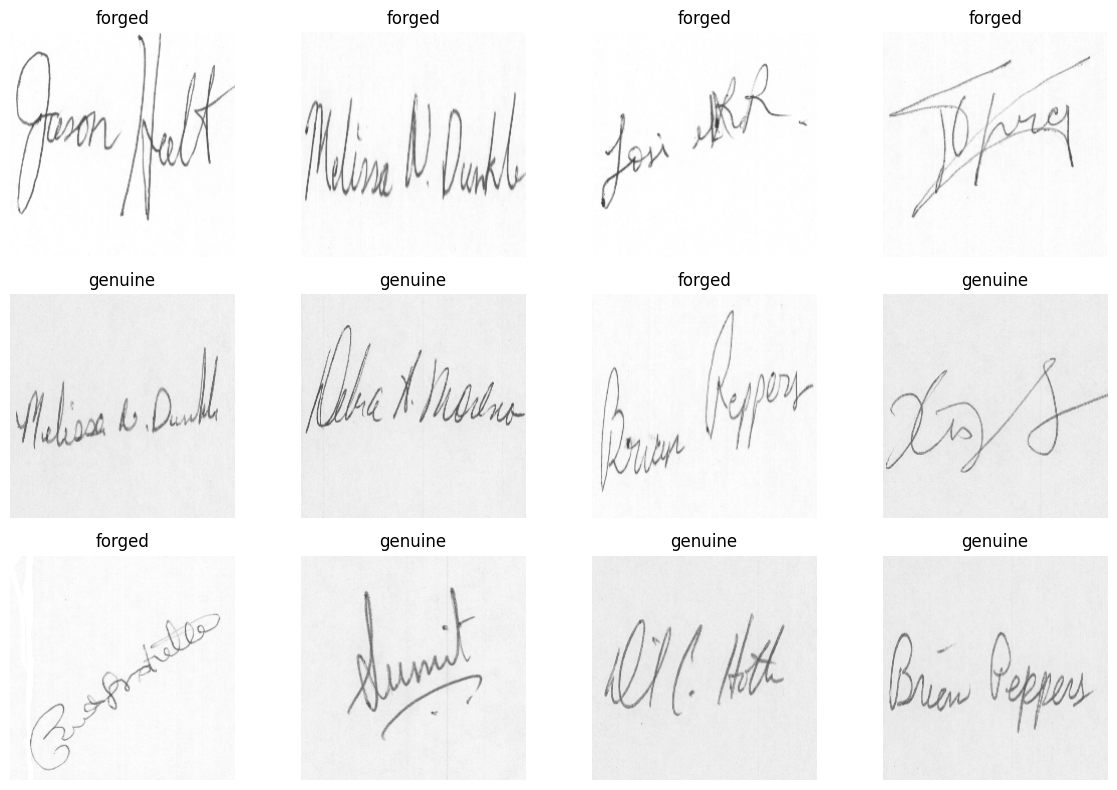

In [31]:
# Visualize a few samples to check if data loaded correctly
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(12, len(images))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Preprocessing & Augmentation
We build a preprocessing pipeline that:
1. Rescales pixel values to [0, 1] (Normalization). 
2. Applies data augmentation (Random Flip, Rotation, Zoom) to prevent overfitting.

In [32]:
# Configure dataset for performance (caching in memory)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Define Data Augmentation Layer
data_augmentation = models.Sequential([
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    # NOTE: No Rescaling(1./255) here!
], name='aug_mobilenet')



## 5. CNN Model Design
We will design a custom CNN architecture suitable for binary image classification.
- **Conv2D**: Extracts features (edges, curves).
- **MaxPooling2D**: Reduces spatial dimensions.
- **Dropout**: Prevents overfitting.
- **Dense**: Classification layers.
- **Sigmoid Output**: Returns probability between 0 and 1.

In [33]:
def build_improved_cnn():
    """
    Deeper CNN with BatchNormalization for better convergence
    """
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        data_augmentation,
        
        # Block 1
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ], name='improved_cnn')
    
    return model

cnn_model = build_improved_cnn()
cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)
cnn_model.summary()

Model: "improved_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ aug_mobilenet (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,02

 Total params: 26,013,217 (99.23 MB)

 Trainable params: 26,011,809 (99.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [34]:
# Callbacks for Training
cnn_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint('signature_model_cnn_best.keras', save_best_only=True, monitor='val_accuracy', verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

print("\nTraining Custom CNN...")
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=cnn_callbacks,
    verbose=1
)


Training Custom CNN...
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8972 - auc: 0.9522 - loss: 0.2077 - precision: 0.9306 - recall: 0.8662
Epoch 1: val_accuracy improved from None to 0.51034, saving model to signature_model_cnn_best.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9640 - auc: 0.9968 - loss: 0.0766 - precision: 0.9755 - recall: 0.9522 - val_accuracy: 0.5103 - val_auc: 0.5000 - val_loss: 28.7151 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9860 - auc: 0.9998 - loss: 0.0314 - precision: 0.9963 - recall: 0.9772
Epoch 2: val_accuracy did not improve from 0.51034
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9931 - auc: 0.9998 - loss: 0.0188 - precision: 0.9966 - recall: 0.9898 - val_accuracy: 0.5103 - val_auc: 0.5000 - val_loss: 23.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━

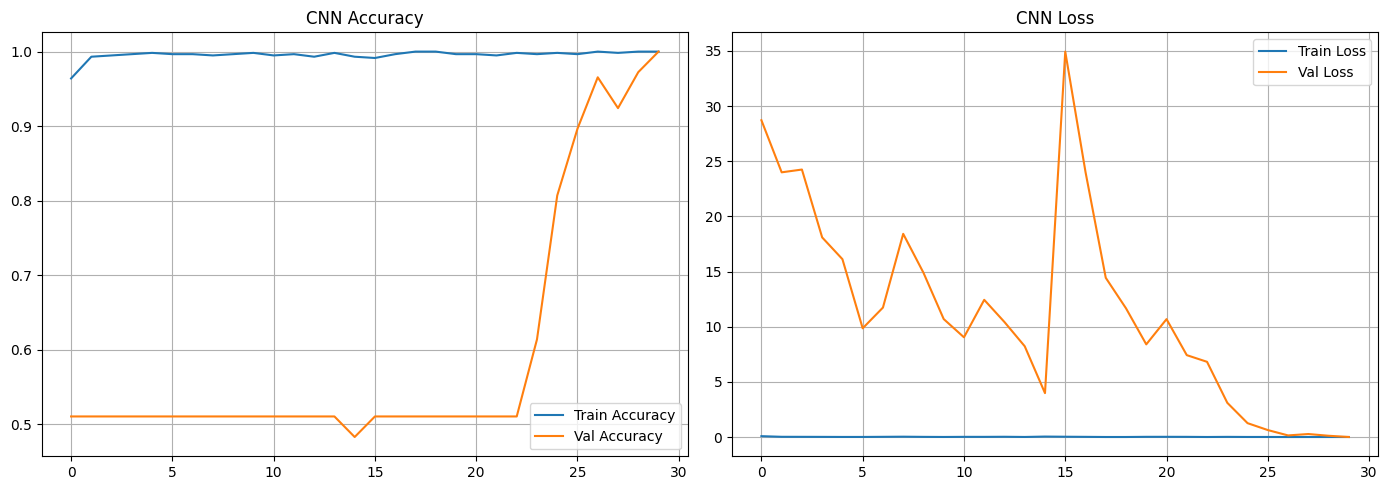

In [35]:
## Plot CNN Training History
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('CNN Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('CNN Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.1 Alternative: Transfer Learning (MobileNetV2)
This model uses a pre-trained backbone (MobileNetV2) to improve accuracy.


In [36]:
def build_mobilenet_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False # Freeze base model initially

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs, name='mobilenet_signature')

mobilenet_model = build_mobilenet_model()
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

mobilenet_model.summary()



Model: "mobilenet_signature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_mobilenet (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,089 (10.01 MB)

 Trainable params: 364,033 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

## 6. Training
We train the model using:
- **Loss**: Binary Crossentropy
- **Optimizer**: Adam
- **Callbacks**: EarlyStopping (to stop when validation loss stops improving) and ModelCheckpoint.

In [37]:


mobilenet_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint('signature_model_mobilenet_best.keras', save_best_only=True, monitor='val_accuracy', verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

print("Phase 1: Training Head (Feature Extraction)...")
mobilenet_history = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=mobilenet_callbacks,
    verbose=1
)
#Fine-tuning Phase
print("\nPhase 2: Fine-Tuning MobileNetV2...")
mobilenet_model.layers[2].trainable = True # Unfreeze base model
mobilenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

mobilenet_history_fine = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    initial_epoch=len(mobilenet_history.history['accuracy']),
    callbacks=mobilenet_callbacks,
    verbose=1
)

Phase 1: Training Head (Feature Extraction)...
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6041 - auc: 0.6562 - loss: 0.8082 - precision: 0.6063 - recall: 0.6355
Epoch 1: val_accuracy improved from None to 0.60690, saving model to signature_model_mobilenet_best.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.6810 - auc: 0.7638 - loss: 0.6725 - precision: 0.6720 - recall: 0.7133 - val_accuracy: 0.6069 - val_auc: 0.9408 - val_loss: 0.6597 - val_precision: 0.5547 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8336 - auc: 0.9181 - loss: 0.3817 - precision: 0.8445 - recall: 0.8262
Epoch 2: val_accuracy did not improve from 0.60690
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.8525 - auc: 0.9321 - loss: 0.3377 - precision: 0.8439 - recall: 0.8669 - val_accuracy: 0.6000 - val_auc: 0.9554 - val_loss: 0.7772 - val_precision: 0.5504 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10


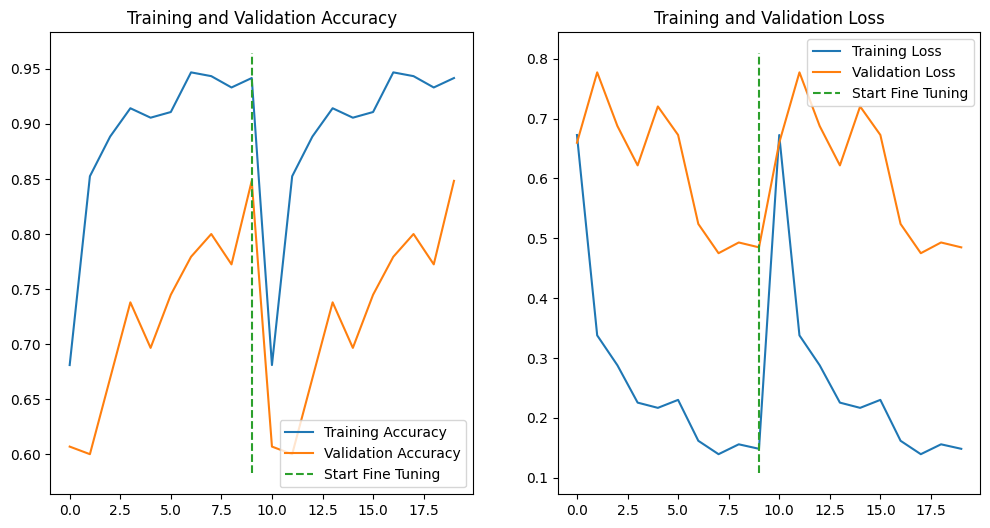

In [38]:
# Plot Training History (Combined)
acc = mobilenet_history.history['accuracy'] + mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy'] + mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss'] + mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss'] + mobilenet_history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([len(mobilenet_history.history['accuracy'])-1, len(mobilenet_history.history['accuracy'])-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(mobilenet_history.history['accuracy'])-1, len(mobilenet_history.history['accuracy'])-1], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 7. Evaluation
We evaluate the model on the unseen test set using Confusion Matrix and ROC Curve.

FINAL MODEL EVALUATION

--- Custom CNN Evaluation ---
Test Accuracy: 100.00%
Test AUC: 1.0000

--- MobileNetV2 Evaluation ---
Test Accuracy: 89.13%
Test AUC: 0.9667

🏆 Best Model Selected: Custom CNN
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step


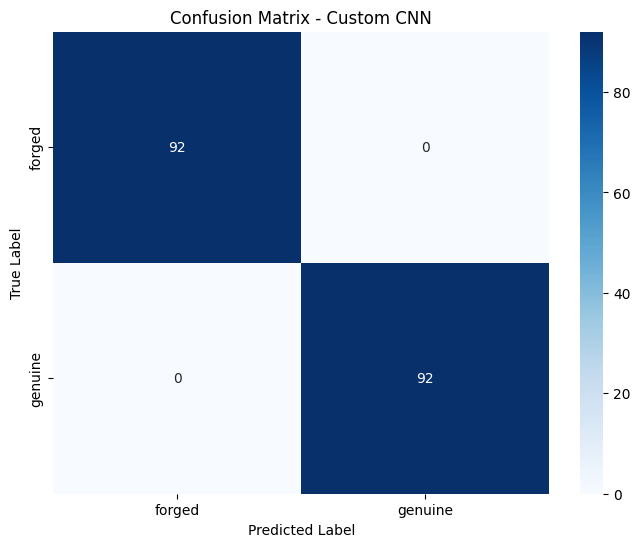


Classification Report:

              precision    recall  f1-score   support

      forged       1.00      1.00      1.00        92
     genuine       1.00      1.00      1.00        92

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



In [39]:
print("FINAL MODEL EVALUATION")
print("="*50)

# Evaluate CNN
print("\n--- Custom CNN Evaluation ---")
cnn_results = cnn_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {cnn_results[1]*100:.2f}%")
print(f"Test AUC: {cnn_results[4]:.4f}")

# Evaluate MobileNet
print("\n--- MobileNetV2 Evaluation ---")
mobilenet_results = mobilenet_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {mobilenet_results[1]*100:.2f}%")
print(f"Test AUC: {mobilenet_results[4]:.4f}")

# Choose best model automatically
if mobilenet_results[1] > cnn_results[1]:
    best_model = mobilenet_model
    best_model_name = "MobileNetV2"
else:
    best_model = cnn_model
    best_model_name = "Custom CNN"

print(f"\n🏆 Best Model Selected: {best_model_name}")

# Confusion Matrix & Report
predictions = best_model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0).flatten()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

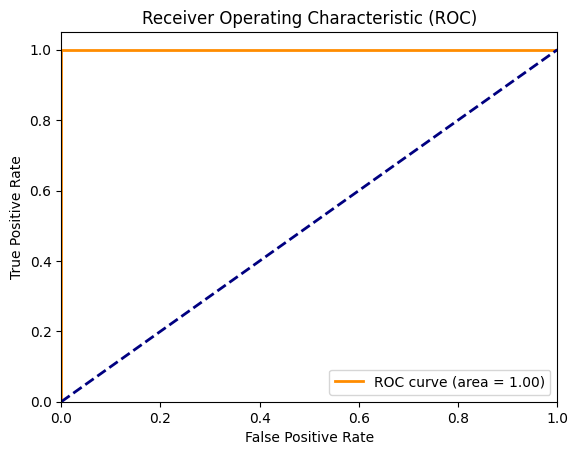

In [40]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 8. Prediction & Verification Logic
We create a standalone function to verify a single signature image.

Testing Verification Function on unseen data...

Testing Genuine Sample: DataSet/data\test\genuine\original_10_1.png


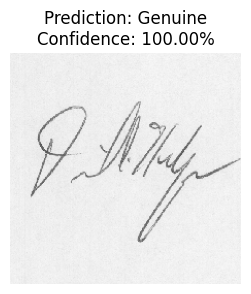


Testing Forged Sample: DataSet/data\test\forged\forgeries_10_12.png


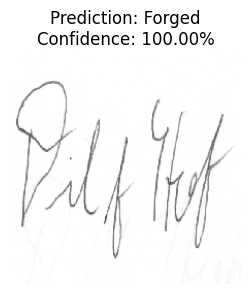


Model saved successfully as: final_signature_model_Custom_CNN.keras


In [41]:
def verify_signature(image_path, model=best_model, threshold=0.5):
    """
    Verify if a signature is genuine or forged
    """
    try:
        # Load image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        
        # === CRITICAL FIX ===
        # Do NOT divide by 255.0 here. 
        # The MobileNet model has 'preprocess_input' inside it.
        # The CNN model has 'Rescaling' layer inside it.
        # They both expect raw 0-255 inputs.
        
        prediction = model.predict(img_array, verbose=0)[0][0]
        
        label = "Genuine" if prediction > threshold else "Forged"
        confidence = prediction if label == "Genuine" else 1 - prediction
        
        plt.figure(figsize=(5, 3))
        plt.imshow(img)
        plt.title(f"Prediction: {label}\nConfidence: {confidence*100:.2f}%")
        plt.axis("off")
        plt.show()
        
        return label, float(prediction)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Test on a few samples from Test Set
print("Testing Verification Function on unseen data...")

# Get one sample from each class in the test directory
genuine_sample = os.path.join(DATA_DIR, 'test', 'genuine', os.listdir(os.path.join(DATA_DIR, 'test', 'genuine'))[0])
forged_sample = os.path.join(DATA_DIR, 'test', 'forged', os.listdir(os.path.join(DATA_DIR, 'test', 'forged'))[0])

print(f"\nTesting Genuine Sample: {genuine_sample}")
verify_signature(genuine_sample)

print(f"\nTesting Forged Sample: {forged_sample}")
verify_signature(forged_sample)

# Save the final best model
final_name = f"final_signature_model_{best_model_name.replace(' ', '_')}.keras"
best_model.save(final_name)
print(f"\nModel saved successfully as: {final_name}")

## 9. Offline Usage
The model is saved as `signature_model.keras`. You can load it later without retraining.

Model loaded successfully!


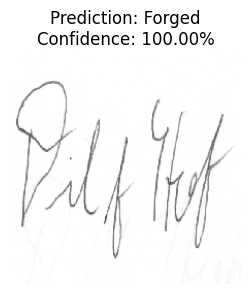

('Forged', 2.3118722310755402e-05)

In [42]:
# Load the model
loaded_model = tf.keras.models.load_model('signature_model_mobilenet_best.keras')
print("Model loaded successfully!")

# Use loaded model
verify_signature(forged_sample, loaded_model)

Selected Image from full_org: DataSet\full_org\original_8_16.png
Loading model from signature_model_mobilenet_best.keras...
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Prediction: Forged Signature (Score: 0.0008)
Result: Forged


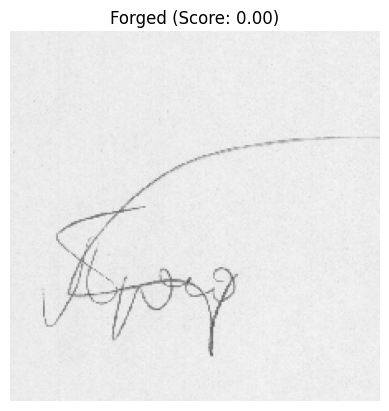

In [63]:
def verify_signature(image_path, model):
    try:
        # Load image (ensure standard size used in training, typically 224x224 for MobileNetV2)
        # Using target_size=(224, 224) based on typical MobileNetV2 usage.
        # If the model was trained with a different size, this should be adjusted.
        img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

        prediction = model.predict(img_array)
        score = prediction[0][0]

        # Display information about the prediction
        # Assuming < 0.5 is Forged (0) and > 0.5 is Genuine (1) based on typical binary classification
        if score < 0.5:
             print(f"Prediction: Forged Signature (Score: {score:.4f})")
        else:
             print(f"Prediction: Genuine Signature (Score: {score:.4f})")
             
        # Determine strict label
        label = "Forged" if score < 0.5 else "Genuine"
        print(f"Result: {label}")

        # Plotting might not work well in non-interactive terminal, but keeping it for completeness
        plt.imshow(img)
        plt.title(f"{label} (Score: {score:.2f})")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error verifying signature: {e}")

def main():
    # Base path for dataset
    base_dir = "DataSet"
    
    # Verify dataset existence
    if not os.path.exists(base_dir):
        print(f"Error: Dataset directory '{base_dir}' not found.")
        return

    # Categories
    categories = ["full_forg", "full_org"]
    
    # Select random category
    selected_category = random.choice(categories)
    category_path = os.path.join(base_dir, selected_category)

    if os.path.exists(category_path):
        files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if files:
            # Select random file
            random_file = random.choice(files)
            image_path = os.path.join(category_path, random_file)
            print(f"Selected Image from {selected_category}: {image_path}")
            
            # Load model
            model_path = 'signature_model_mobilenet_best.keras'
            if os.path.exists(model_path):
                print(f"Loading model from {model_path}...")
                try:
                    loaded_model = tf.keras.models.load_model(model_path)
                    print("Model loaded successfully!")
                    
                    # Verify
                    verify_signature(image_path, loaded_model)
                except Exception as e:
                    print(f"Error loading model: {e}")
            else:
                print(f"Model file '{model_path}' not found.")
        else:
            print(f"No image files found in {category_path}")
    else:
        print(f"Category directory {category_path} not found.")

if __name__ == "__main__":
    main()
